In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import darts
from darts import TimeSeries

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("./datasets/DCFC_load.csv")
load_df = df.drop((['Unnamed: 2','Unnamed: 3','Unnamed: 4','Unnamed: 5','Unnamed: 6','Unnamed: 7']),axis=1)
time = pd.to_datetime(load_df['Time'], format='%d/%m/%y %H:%M')

time_train = time[:23328]
x_train = load_df["PowerkW2"][:23328]

time_cv = time[23328:]
x_cv = load_df["PowerkW2"][23328:]

In [3]:
import pandas as pd

# Assuming your existing DataFrame is named load_df
# If not, replace 'load_df' with the actual name of your DataFrame
load_df['Time'] = pd.to_datetime(load_df['Time'], format='%d/%m/%y %H:%M')

# Create a new DataFrame with 15-minute intervals
start_time = load_df['Time'].min()
end_time = load_df['Time'].max()
new_time_range = pd.date_range(start=start_time, end=end_time, freq='15T')
new_df = pd.DataFrame({'Time': new_time_range})

# Replace the 'Time' column in the original DataFrame with the new one
load_df['Time'] = new_df['Time']

new_row = {'Time': pd.Timestamp('2022-01-02 00:00:00'), 'PowerkW2': 0.0}

# Find the index of the row with the specified timestamp
index_of_timestamp = load_df[load_df['Time'] == pd.Timestamp('2022-01-01 23:45:00')].index[0]

# Insert the new row after the specified timestamp
load_df = pd.concat([load_df.iloc[:index_of_timestamp + 1], pd.DataFrame([new_row], columns=load_df.columns), load_df.iloc[index_of_timestamp + 1:]], ignore_index=True)

load_df.drop(96, inplace=True)


In [4]:
load_df['Time'][35040] = pd.Timestamp('2022-12-31 23:45:00')
load_df[135:150]

,Time,PowerkW2
136,2022-01-02 09:45:00,0.000000
137,2022-01-02 10:00:00,0.000000
138,2022-01-02 10:15:00,0.000000
139,2022-01-02 10:30:00,0.000000
140,2022-01-02 10:45:00,0.000000
141,2022-01-02 11:00:00,0.000000
142,2022-01-02 11:15:00,0.000000
143,2022-01-02 11:30:00,0.000000
144,2022-01-02 11:45:00,0.000000
145,2022-01-02 12:00:00,0.000000


In [18]:
load_df["PowerkW2"] = load_df["PowerkW2"].astype(np.float32)

In [19]:
type(load_df["PowerkW2"][0])

numpy.float32

In [20]:
series = TimeSeries.from_dataframe(load_df, time_col='Time', freq = '15T')

<Axes: xlabel='Time'>

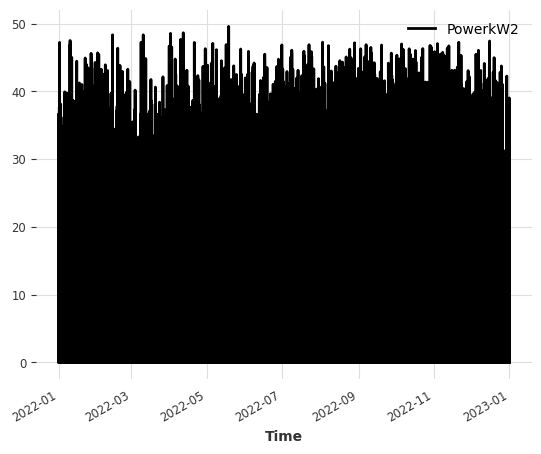

In [21]:
series.plot()

In [22]:
from darts.utils.statistics import check_seasonality

is_daily_seasonal, daily_period = check_seasonality(series, m=96, max_lag=400, alpha=0.05)
is_weekly_seasonal, weekly_period = check_seasonality(series, m=672, max_lag=1000, alpha=0.05)

print(f'Daily seasonality: {is_daily_seasonal} - period = {daily_period}')
print(f'Weekly seasonality: {is_weekly_seasonal} - period = {weekly_period}')

Daily seasonality: True - period = 96
Weekly seasonality: True - period = 672


<Axes: xlabel='Time'>

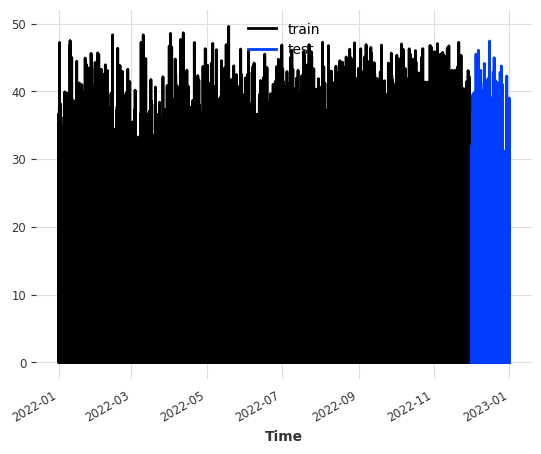

In [23]:
train, test = series[:-2976], series[-2976:]

train.plot(label='train')
test.plot(label='test')

In [24]:
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler

In [25]:
train_scaler = Scaler()
scaled_train = train_scaler.fit_transform(train)

In [26]:
nbeats = NBEATSModel(
    input_chunk_length=672, 
    output_chunk_length=96,
    generic_architecture=True,
    random_state=42)

In [28]:
nbeats.fit(
    scaled_train,
    epochs=5)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 11.3 M
---------------------------------------------------
11.3 M    Trainable params
5.3 K     Non-trainable params
11.3 M    Total params
45.221    Total estimated model params size (MB)


Training: |                                               | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


NBEATSModel(generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=672, output_chunk_length=96, random_state=42)

In [42]:
scaled_pred_nbeats = nbeats.predict(n=2976)

pred_nbeats = train_scaler.inverse_transform(scaled_pred_nbeats)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                             | 0/? [00:00<?, ?it/s]

NotImplementedError: The operator 'aten::roll' is not currently implemented for the MPS device. If you want this op to be added in priority during the prototype phase of this feature, please comment on https://github.com/pytorch/pytorch/issues/77764. As a temporary fix, you can set the environment variable `PYTORCH_ENABLE_MPS_FALLBACK=1` to use the CPU as a fallback for this op. WARNING: this will be slower than running natively on MPS.

In [ ]:
mae_nbeats = mae(test, pred_nbeats)

print(mae_nbeats)

In [ ]:
mase_nbeats = mse(test, pred_nbeats)

print(mse_nbeats)